In [1]:
import matplotlib.pyplot as plt
import seaborn as sn
import pickle
import csv
import os
import random
import zipfile
import tensorflow as tf
from math import ceil
import json
import pgeocode
import re
from sklearn.model_selection import train_test_split
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from bs4 import BeautifulSoup  
import pandas as pd  
import requests
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor


In [2]:
df = pd.read_csv('data.csv', sep =',', error_bad_lines=False)

C:\Users\Sony\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3441: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103115 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226470 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

In [4]:
df.head(2)

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"


In [5]:
df.dropna(subset = ['target'] ,inplace=True) # строк с отсутствующими данными по таргету не так много, удалим их 

In [6]:
df.target.str.contains('mo', regex = False, na = False).sum() # удалим строки, где  указан ежемесячный (аренда) таргет

398

In [7]:
# подготовим цель удалив лишние знаки и преобразовав в число
per_month = df[df.target.str.contains('mo', regex = False, na = False)].index
df.drop(per_month, inplace = True)
df['target'] = df['target'].str.replace('$', '')
df['target'] = df['target'].str.replace(',', '')
df['target'] = df['target'].str.replace('+', '')
df['target'] = df['target'].apply(int)

C:\Users\Sony\anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  after removing the cwd from sys.path.
C:\Users\Sony\anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  


In [8]:

df.status.nunique() # не несет полезной информации влияющей на стоимость-  удалим данную колонку

155

In [9]:
df.propertyType.nunique() # оставим данную колонку

1279

In [10]:
df['street'].nunique() # не влияет на цену - удалим данную колонку

334447

In [11]:
df['baths'].nunique() 

225

In [12]:
# при преобразовании baths во float вылезло много лишних символом, почистим их
df['baths'] = df['baths'].str.replace('Baths', '')
df['baths'] = df['baths'].str.replace('Bath', '')
df['baths'] = df['baths'].str.replace('rooms:', '')
df['baths'] = df['baths'].str.replace(',', '.')
df['baths'] = df['baths'].str.replace('ba', '.')
df['baths'] = df['baths'].str.replace('ba', '')
df['baths'] = df['baths'].str.replace(' .', '')
df['baths'] = df['baths'].str.replace('~', '')
df['baths'] = df['baths'].str.replace('+', '')
df['baths'] = df['baths'].str.replace('—', '0')
df['baths'] = df['baths'].str.replace('ths', '')
df['baths'] = df['baths'].str.replace('emiMod', '0')

C:\Users\Sony\anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  
C:\Users\Sony\anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  # Remove the CWD from sys.path while we load stuff.


In [13]:
# удалим "непонятные" данные
ba = df[df.baths==  ''].index
df.loc[ba, 'baths'] = np.nan
Sq_t = df[df.baths.str.contains('Sq.t. ', regex = False, na = False)].index
df.drop(Sq_t, inplace = True)
mult = df[df.baths.str.contains('-', regex = False, na = False)].index
df.drop(mult, inplace = True)
_ths = df[df.baths==  '--ths'].index
df.loc[_ths, 'baths'] = np.nan


In [14]:
df['baths'].apply(float)

0         3.5
1         3.0
2         2.0
3         8.0
4         NaN
         ... 
377180    6.0
377181    3.0
377182    3.0
377183    NaN
377184    2.0
Name: baths, Length: 373607, dtype: float64

In [15]:
df.homeFacts[3304]# в данной колонке homeFacts хранятся важные данные- год постройки, ремонт, отопление, охлождение, 
# место для авто, квадратура территории, цена за кв фут

"{'atAGlanceFacts': [{'factValue': '2019', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': '', 'factLabel': 'Heating'}, {'factValue': 'Central A/C (Electric), Central Heat (Electric)', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': '—', 'factLabel': 'lotsize'}, {'factValue': '$124 / Sq. Ft.', 'factLabel': 'Price/sqft'}]}"

In [16]:
df.homeFacts.str.contains("[a-z](')[a-z]").sum()

C:\Users\Sony\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


333

In [17]:
# таких записей всего лишь 333, количество наших данных позволяет нам не мучаться и удалить их
v = df[df.homeFacts.str.contains("[a-z](')[a-z]")].index
df.drop(v, inplace = True)

C:\Users\Sony\anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


In [18]:
df.homeFacts = df.homeFacts.str.replace("'", '"')
df.homeFacts = df.homeFacts.str.replace("/", ' ')
df['homeFacts'] = df['homeFacts'].str.replace('None', '""')
df.homeFacts = df.homeFacts.str.replace('""""', '""')
df.homeFacts = df.homeFacts.str.replace('"""', '"')
df.homeFacts = df.homeFacts.str.replace('"closet"', 'closet')
df.homeFacts = df.homeFacts.str.replace('Carport, "", Attached Garage', 'Carport, Attached Garage')

In [19]:
def get_Year_built (homefacts):
    try:
        homefacts = json.loads(homefacts) # превращает json строку в json объект 
        year = homefacts ["atAGlanceFacts"][0]["factValue"]
        return year
    except Exception as e:
        print (e)
        print (homefacts)
        return np.nan
df['year_built'] = df.homeFacts.apply(get_Year_built)

In [20]:
#df.year_built = df.year_built.apply(int)
df[df.year_built=='']

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,year_built
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{""atAGlanceFacts"": [{""factValue"": """", ""factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,5000,
26,Active,NaN,NaN,5755 SW 123 Ave,1.000,"{""atAGlanceFacts"": [{""factValue"": """", ""factLab...",NaN,Miami,"[{'rating': ['9', '10', 'NR', '6', '3'], 'data...",NaN,33183,Baths,FL,NaN,NaN,NaN,A10787617,799000,
27,for sale,NaN,single-family home,2104 Lou Ellen Ln #B,3,"{""atAGlanceFacts"": [{""factValue"": """", ""factLab...",NaN,Houston,"[{'rating': ['6/10', '9/10', '3/10'], 'data': ...","2,575 sqft",77018,3 Beds,TX,NaN,NaN,NaN,33856933,499900,
40,Active,NaN,NaN,1104 Rotonda Cir,NaN,"{""atAGlanceFacts"": [{""factValue"": """", ""factLab...",NaN,ROTONDA WEST,"[{'rating': ['6', '6', '7'], 'data': {'Distanc...",NaN,33947,NaN,FL,NaN,NaN,NaN,D6107075,54000,
41,for sale,NaN,lot/land,9418 Camino Santa Fe #19,NaN,"{""atAGlanceFacts"": [{""factValue"": """", ""factLab...",NaN,San Diego,"[{'rating': ['9/10', '9/10', '9/10'], 'data': ...",NaN,92127,NaN,CA,NaN,NaN,NaN,190057878,1100000,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377141,Active,NaN,NaN,Mantova Ct,NaN,"{""atAGlanceFacts"": [{""factValue"": """", ""factLab...",NaN,ORLANDO,"[{'rating': ['7', '6', 'NR', 'NR', '7'], 'data...",NaN,32836,NaN,FL,NaN,NaN,NaN,O5763033,400000,
377153,Active,NaN,Single Family Home,17030 Youngblood Rd.,3.5,"{""atAGlanceFacts"": [{""factValue"": """", ""factLab...",NaN,Charlotte,"[{'rating': ['9', '5', '6', '7', '3', '2', 'NR...","3,104",28278,4,NC,NaN,NaN,NaN,161520253,445900,
377154,Active,NaN,NaN,2104 Russell Ave,NaN,"{""atAGlanceFacts"": [{""factValue"": """", ""factLab...",NaN,Charlotte,"[{'rating': ['2', '3', '3'], 'data': {'Distanc...",NaN,28216,NaN,NC,NaN,NaN,NaN,3571015,99990,
377161,Active,NaN,Land,Homestead Dr Lot 1,NaN,"{""atAGlanceFacts"": [{""factValue"": """", ""factLab...",NaN,Columbiana,"[{'rating': ['8', '9', '8', 'NR'], 'data': {'D...",0,44408,NaN,OH,NaN,NaN,NaN,3382834,45000,


In [21]:
def remodeled (homefacts ):
    homefacts = json.loads(homefacts) # превращает json строку в json объект 
    chek = homefacts ["atAGlanceFacts"][1]["factValue"]
    if chek != '':
        return chek
    else:
        return 'no'

df['remodeled_year'] = df.homeFacts.apply(remodeled)


In [22]:
df[df.remodeled_year=='']

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,year_built,remodeled_year


In [23]:
r = df[df.remodeled_year == 'no'].index
df.loc[r, 'remodeled_year'] = df.loc[r, 'year_built']

будем использовать json. он работает только с двойными ковычками, следовательно нам необходимо заменить одинарные на двойные. однако тут возникает путаница с текстом содержащим апострофы. проверим количество подобных записей

In [24]:
# заменим все мешающие нам знаки, создадим функцию по созданию lotsize и записи туда данных о размере земельного участка
def get_lotsize (homefacts):
    try:
        homefacts = json.loads(homefacts) # превращает json строку в json объект 
        asd = homefacts ["atAGlanceFacts"][5]["factValue"].replace(',', '')
        return asd
    except Exception as e:
        print (e)
        print (homefacts)
        return np.nan
df['lotsize'] = df.homeFacts.apply(get_lotsize)

In [25]:
get_lotsize(df.iloc[3116, 5])

'2.6 acres'

In [26]:
def get_Heating (homefacts):
    try:
        homefacts = json.loads(homefacts) # превращает json строку в json объект 
        heat = homefacts ["atAGlanceFacts"][2]["factValue"]
        return heat
    except Exception as e:
        print (e)
        print (homefacts)
        return np.nan
df['heating'] = df.homeFacts.apply(get_Heating)

In [27]:
def get_cooling (homefacts):
    try:
        homefacts = json.loads(homefacts) # превращает json строку в json объект 
        cool = homefacts ["atAGlanceFacts"][3]["factValue"]
        return cool
    except Exception as e:
        print (e)
        print (homefacts)
        return np.nan
df['cooling'] = df.homeFacts.apply(get_cooling)

In [28]:
def get_parking (homefacts):
    try:
        homefacts = json.loads(homefacts) # превращает json строку в json объект 
        parking = homefacts ["atAGlanceFacts"][4]["factValue"]
        return parking
    except Exception as e:
        print (e)
        print (homefacts)
        return np.nan
df['parking'] = df.homeFacts.apply(get_parking)

In [29]:
#df.drop('homeFacts', axis = 1, inplace = True)

In [30]:
df.head(5)

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,...,mls-id,PrivatePool,MlsId,target,year_built,remodeled_year,lotsize,heating,cooling,parking
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{""atAGlanceFacts"": [{""factValue"": ""2019"", ""fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,...,NaN,NaN,611019,418000,2019,2019,,"Central A C, Heat Pump",,
1,for sale,NaN,single-family home,12911 E Heroy Ave,3,"{""atAGlanceFacts"": [{""factValue"": ""2019"", ""fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",...,NaN,NaN,201916904,310000,2019,2019,5828 sqft,,,
2,for sale,NaN,single-family home,2005 Westridge Rd,2,"{""atAGlanceFacts"": [{""factValue"": ""1961"", ""fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",...,NaN,yes,FR19221027,2895000,1961,1967,8626 sqft,Forced Air,Central,Attached Garage
3,for sale,NaN,single-family home,4311 Livingston Ave,8,"{""atAGlanceFacts"": [{""factValue"": ""2006"", ""fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",...,NaN,NaN,14191809,2395000,2006,2006,8220 sqft,Forced Air,Central,Detached Garage
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{""atAGlanceFacts"": [{""factValue"": """", ""factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,...,NaN,NaN,861745,5000,,,10019 sqft,,,


In [31]:
df['fireplace'][1516 ] 
# признак наверное влияет на цену, но очень много отсутствующих значений. считаю отсутсвие данных=отсутствию fireplace

'Ceiling Fan, Walk-In Closets, Wood Burning FP'

In [32]:
df.fireplace = df.fireplace.str.replace('Not Applicable','no') # заменим "непригодный" на "нет"


In [33]:
df.fireplace = df.fireplace.fillna('no')


In [34]:
df.fireplace.unique()

array(['Gas Logs', 'no', 'yes', ...,
       'Ceiling Fan, Fire Sprinkler System, Storage, Utility Connection',
       'Fireplace-Gas, Fireplace-Wood, Patio, Walk-in Closet',
       'Ceiling Fan, SMAPL, Utility Connection, Walk-In Closets'],
      dtype=object)

In [35]:
# сохраним все данные где есть записи и превраим их в yes
f = df[~(df.fireplace == 'no')].index

In [36]:
df.loc[f, 'fireplace']='yes'

In [37]:
def fp_pool_identifier(column):
    if len (column) == 2:
        return  0
    else:
        return  1

In [38]:
df.fireplace = df.fireplace.apply(fp_pool_identifier)

In [39]:
df.city.nunique() # удалми данную колонку- не влияет на цену.

2015

In [40]:
df.schools.nunique()
df.schools[3] # нужый признак. создадим несколько признаков : категориальный - какие классы в школах, 
#категориальный среднее расстояние до школ

"[{'rating': ['9/10', '9/10', '10/10', '9/10'], 'data': {'Distance': ['1.05mi', '0.1mi', '1.05mi', '0.81mi'], 'Grades': ['5-6', 'PK-4', '7-8', '9-12']}, 'name': ['Mcculloch Intermediate School', 'Bradfield Elementary School', 'Highland Park Middle School', 'Highland Park High School']}]"

In [41]:
df.sqft.nunique() # однин из самых значимых признаков.

25294

In [42]:
df.zipcode.nunique() # важный признак. с помощью pgeocode вытащим latitude и longitude

4536

In [43]:
#nomi = pgeocode.Nominatim('US')
#coord = df['zipcode']. apply(nomi.query_postal_code)
#coord.to_csv('coord.csv', encoding='utf-8', index=False)



In [44]:
coord = pd.read_csv('coord.csv', sep =',', error_bad_lines=False)

C:\Users\Sony\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3441: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [45]:
coord.head(2)

,postal_code,country_code,place_name,state_name,state_code,county_name,county_code,community_name,community_code,latitude,longitude,accuracy
0,28387,US,Southern Pines,North Carolina,NC,Moore,125.0,NaN,NaN,35.1697,-79.3957,4.0
1,99216,US,Spokane,Washington,WA,Spokane,63.0,NaN,NaN,47.6634,-117.2193,4.0


In [46]:
df['latitude'] = coord['latitude']
df['longitude'] = coord['longitude']

In [47]:
df.head(2)

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,...,MlsId,target,year_built,remodeled_year,lotsize,heating,cooling,parking,latitude,longitude
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{""atAGlanceFacts"": [{""factValue"": ""2019"", ""fac...",1,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,...,611019,418000,2019,2019,,"Central A C, Heat Pump",,,35.1697,-79.3957
1,for sale,NaN,single-family home,12911 E Heroy Ave,3,"{""atAGlanceFacts"": [{""factValue"": ""2019"", ""fac...",0,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",...,201916904,310000,2019,2019,5828 sqft,,,,47.6634,-117.2193


In [48]:
df['mls-id'].nunique() # не несет полезной информации-  удалим данную колонку

24465

In [49]:
df['beds'].value_counts() # важный признак. необходимо разобрать колонку, так как содержит квадратуру

3 Beds        52947
4 Beds        35149
3             31079
2 Beds        26084
4             19853
              ...  
8.93 acres        1
5,510 sqft        1
3.8 acres         1
7,104 sqft        1
8,479 sqft        1
Name: beds, Length: 1140, dtype: int64

In [50]:
df.beds = df.beds.str.replace('Beds','') # заменим Beds на пустое значение

In [51]:
df.beds = df.beds.str.replace('bd','') # заменим bd на пустое значение

In [52]:
df['beds'][2135]

'0.6 acres'

In [53]:
a = df[(df.beds == 'Baths') | (df.beds == 'Bath')].index 
# создадим перемнную, где в колонке beds содержаться слова Baths или Bath

In [54]:
df.loc[a]

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,...,MlsId,target,year_built,remodeled_year,lotsize,heating,cooling,parking,latitude,longitude
16,Active,NaN,NaN,2402 NW 22nd Rd,1.750,"{""atAGlanceFacts"": [{""factValue"": ""2008"", ""fac...",0,Fort Lauderdale,"[{'rating': ['4', 'NR', '3', 'NR'], 'data': {'...","2,203",...,F10207914,335000,2008,2009,5304 Sq. Ft.,,,,26.1421,-80.1728
22,Active,NaN,"Penthouse, Split-Level",120 Jefferson Ave #12019,1.000,"{""atAGlanceFacts"": [{""factValue"": ""1996"", ""fac...",0,Miami Beach,"[{'rating': ['7', '10', 'NR', '4', '4'], 'data...","1,080",...,A10786027,579000,1996,1996,—,Central Air,Has Cooling,,25.7873,-80.1564
26,Active,NaN,NaN,5755 SW 123 Ave,1.000,"{""atAGlanceFacts"": [{""factValue"": """", ""factLab...",0,Miami,"[{'rating': ['9', '10', 'NR', '6', '3'], 'data...",NaN,...,A10787617,799000,,,—,,,,25.7000,-80.4130
115,Active,NaN,"1 Story, Ranch",110 Munden Dr,2.500,"{""atAGlanceFacts"": [{""factValue"": ""1963"", ""fac...",0,San Antonio,"[{'rating': ['4', '4', '4'], 'data': {'Distanc...","1,470",...,1425285,199900,1963,1963,9716 Sq. Ft.,Natural Gas Heat,Central Heating,,37.3249,-121.9153
120,Active,NaN,NaN,MLS #: UCOM1861406,NaN,"{""atAGlanceFacts"": [{""factValue"": """", ""factLab...",0,Brooklyn,"[{'rating': ['3', '9', '6', '2'], 'data': {'Di...",NaN,...,UCOM1861406,935000,,,—,,,,36.1260,-115.1454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376959,Active,NaN,NaN,2419A Emmett Ave,2.250,"{""atAGlanceFacts"": [{""factValue"": ""1950"", ""fac...",0,Nashville,"[{'rating': ['2', '1', '3', '8', '1', '1'], 'd...","2,089",...,2106410,419900,1950,1950,7405 Sq. Ft.,Central,Electric,,NaN,NaN
377076,Auction - Active,NaN,NaN,9903 Triple Crown Cir,2.000,"{""atAGlanceFacts"": [{""factValue"": ""1990"", ""fac...",0,ORLANDO,"[{'rating': ['9', '7', '3', '5', '7'], 'data':...","1,456",...,O5831040,210000,1990,1990,5445 Sq. Ft.,Central,Central Air,,NaN,NaN
377106,Active,NaN,Traditional,5919 W Harrow Dr,2.750,"{""atAGlanceFacts"": [{""factValue"": ""2001"", ""fac...",1,Houston,"[{'rating': ['5', '6', '6'], 'data': {'Distanc...","1,597",...,16698494,185000,2001,2001,5060 Sq. Ft.,Central Electric,Central Gas,,NaN,NaN
377158,Active,NaN,Condo/Townhome,10578 High Hollows Dr #269,2.000,"{""atAGlanceFacts"": [{""factValue"": ""1970"", ""fac...",1,Dallas,"[{'rating': ['6', '3', '4', '10'], 'data': {'D...","1,709",...,14218103,164500,1970,1970,—,,"Central A C (Electric), Central Heat (Electric)",,NaN,NaN


In [55]:
df.loc[a, 'beds'] = df.loc[a, 'baths']
# заменим данные в колонке beds - вместо слов Baths и Bath определим туда данные из колонки baths 

In [56]:
#df.loc[b1, ['lotsize']].isna().sum()


In [57]:
b1= df[df.beds.str.contains('acres', regex = False, na = False)].index
b2= df[df.beds.str.contains('acre', regex = False, na = False)].index

# создадим перемнные, где в колонке beds присутствуют слова acres и acre

In [58]:

for b in [b1, b2]    :
    df.loc[b, 'lotsize'] = df.loc[b, 'beds']. apply(lambda x: str(int(43560*float(x.split()[0]))))
    # в колонку lotsize сохраним акры переведенные в футы
    # заменим нулями данные в следующих колонках этих переменных
    df.loc[b, 'stories']= '0'
    df.loc[b, 'baths'] = '0'
    #df.loc[b, 'beds'] = '0'

In [59]:
df.loc[b1, 'beds'] = '0'
df.loc[b2, 'beds'] = '0'

In [60]:
df.loc[b1]

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,...,MlsId,target,year_built,remodeled_year,lotsize,heating,cooling,parking,latitude,longitude
279,NaN,NaN,NaN,127 Grapeland Ave,0,"{""atAGlanceFacts"": [{""factValue"": """", ""factLab...",0,San Antonio,"[{'rating': ['3/10', '4/10', '3/10'], 'data': ...",NaN,...,1368899,46000,,,10890,,,,29.7477,-95.6030
491,NaN,NaN,NaN,Martin Anderson Beac,0,"{""atAGlanceFacts"": [{""factValue"": """", ""factLab...",0,Orlando,"[{'rating': ['6/10', '4/10', '5/10'], 'data': ...",NaN,...,O5731775,495000,,,19166,,,,35.9980,-83.9152
548,NaN,NaN,NaN,7000 E Broadway Ave,0,"{""atAGlanceFacts"": [{""factValue"": """", ""factLab...",0,Tampa,"[{'rating': ['2/10', '3/10', '4/10'], 'data': ...",NaN,...,T3198357,349900,,,62290,,,,25.7825,-80.2341
734,NaN,NaN,NaN,950 Granville Dr,0,"{""atAGlanceFacts"": [{""factValue"": """", ""factLab...",0,Houston,"[{'rating': ['2/10', '2/10', '2/10'], 'data': ...",NaN,...,58400586,75000,,,13939,,,,30.2231,-81.7556
1205,NaN,NaN,NaN,4902 Timberlan St,0,"{""atAGlanceFacts"": [{""factValue"": """", ""factLab...",0,Tampa,"[{'rating': ['6/10', '6/10', '5/10'], 'data': ...",NaN,...,T2288006,1650000,,,422531,,,,25.7022,-80.2978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375951,NaN,NaN,NaN,6704 Gunn Hwy,0,"{""atAGlanceFacts"": [{""factValue"": """", ""factLab...",0,Tampa,"[{'rating': ['8/10', '6/10', '7/10'], 'data': ...",NaN,...,A4424566,599999,,,39204,,,,NaN,NaN
376060,NaN,NaN,NaN,0 Edgerton Ave,0,"{""atAGlanceFacts"": [{""factValue"": """", ""factLab...",0,Orlando,"[{'rating': ['5/10'], 'data': {'Distance': ['5...",NaN,...,O5801978,99000,,,44866,,,,NaN,NaN
376596,NaN,NaN,NaN,00 Trumbo Rd,0,"{""atAGlanceFacts"": [{""factValue"": """", ""factLab...",0,San Antonio,"[{'rating': ['NA', '3/10'], 'data': {'Distance...",NaN,...,1358450,259000,,,1033243,,,,NaN,NaN
376719,NaN,NaN,NaN,606 Casasanta Trl,0,"{""atAGlanceFacts"": [{""factValue"": """", ""factLab...",0,Austin,"[{'rating': ['10/10', '10/10', '8/10'], 'data'...",NaN,...,6672739,655000,,,118483,,,,NaN,NaN


In [61]:
df.loc[b, 'stories'].unique()

array(['0'], dtype=object)

In [62]:
#df.loc[b][df.stories == '2.0'].loc[:,'homeFacts'].values

In [63]:
df.loc[b]

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,...,MlsId,target,year_built,remodeled_year,lotsize,heating,cooling,parking,latitude,longitude
279,NaN,NaN,NaN,127 Grapeland Ave,0,"{""atAGlanceFacts"": [{""factValue"": """", ""factLab...",0,San Antonio,"[{'rating': ['3/10', '4/10', '3/10'], 'data': ...",NaN,...,1368899,46000,,,10890,,,,29.7477,-95.6030
491,NaN,NaN,NaN,Martin Anderson Beac,0,"{""atAGlanceFacts"": [{""factValue"": """", ""factLab...",0,Orlando,"[{'rating': ['6/10', '4/10', '5/10'], 'data': ...",NaN,...,O5731775,495000,,,19166,,,,35.9980,-83.9152
548,NaN,NaN,NaN,7000 E Broadway Ave,0,"{""atAGlanceFacts"": [{""factValue"": """", ""factLab...",0,Tampa,"[{'rating': ['2/10', '3/10', '4/10'], 'data': ...",NaN,...,T3198357,349900,,,62290,,,,25.7825,-80.2341
734,NaN,NaN,NaN,950 Granville Dr,0,"{""atAGlanceFacts"": [{""factValue"": """", ""factLab...",0,Houston,"[{'rating': ['2/10', '2/10', '2/10'], 'data': ...",NaN,...,58400586,75000,,,13939,,,,30.2231,-81.7556
1205,NaN,NaN,NaN,4902 Timberlan St,0,"{""atAGlanceFacts"": [{""factValue"": """", ""factLab...",0,Tampa,"[{'rating': ['6/10', '6/10', '5/10'], 'data': ...",NaN,...,T2288006,1650000,,,422531,,,,25.7022,-80.2978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375972,NaN,NaN,NaN,16010 Red Bass Dr,0,"{""atAGlanceFacts"": [{""factValue"": """", ""factLab...",0,Jacksonville,"[{'rating': ['9/10', '4/10', '4/10'], 'data': ...",NaN,...,NaN,115000,,,43560,,,,NaN,NaN
376060,NaN,NaN,NaN,0 Edgerton Ave,0,"{""atAGlanceFacts"": [{""factValue"": """", ""factLab...",0,Orlando,"[{'rating': ['5/10'], 'data': {'Distance': ['5...",NaN,...,O5801978,99000,,,44866,,,,NaN,NaN
376596,NaN,NaN,NaN,00 Trumbo Rd,0,"{""atAGlanceFacts"": [{""factValue"": """", ""factLab...",0,San Antonio,"[{'rating': ['NA', '3/10'], 'data': {'Distance...",NaN,...,1358450,259000,,,1033243,,,,NaN,NaN
376719,NaN,NaN,NaN,606 Casasanta Trl,0,"{""atAGlanceFacts"": [{""factValue"": """", ""factLab...",0,Austin,"[{'rating': ['10/10', '10/10', '8/10'], 'data'...",NaN,...,6672739,655000,,,118483,,,,NaN,NaN


In [64]:
# создадим функцию , которая будет проверять колонку 
def clean_beds (bed):
    try:
        bed = float(bed)
        return bed
    except:
        if 'sqft' in bed:
            try:
                float(bed.split()[0])
            except:
                print (bed)
        else:    
        
            return np.nan
    
df.beds.apply(clean_beds)
        

8,637 sqft
10,310 sqft
6,250 sqft
5,000 sqft
5,662 sqft
2,200 sqft
2,874 sqft
2,178 sqft
4,356 sqft
5,501 sqft
8,001 sqft
7,405 sqft
1,502 sqft
8,712 sqft
8,189 sqft
8,973 sqft
7,148 sqft
8,494 sqft
-- sqft
10,001 sqft
5,227 sqft
6,551 sqft
7,200 sqft
7,840 sqft
4,948 sqft
7,840 sqft
10,245 sqft
7,501 sqft
10,798 sqft
8,712 sqft
6,268 sqft
3,650 sqft
6,777 sqft
5,745 sqft
2,874 sqft
-- sqft
6,054 sqft
6,900 sqft
5,000 sqft
7,501 sqft
6,037 sqft
-- sqft
2,861 sqft
6,141 sqft
9,369 sqft
6,529 sqft
4,996 sqft
4,861 sqft
9,517 sqft
6,751 sqft
8,712 sqft
6,111 sqft
10,062 sqft
5,148 sqft
6,098 sqft
6,899 sqft
2,265 sqft
2,500 sqft
-- sqft
6,250 sqft
-- sqft
5,924 sqft
10,511 sqft
10,528 sqft
6,708 sqft
10,497 sqft
5,906 sqft
10,001 sqft
6,141 sqft
10,454 sqft
4,996 sqft
10,201 sqft
-- sqft
10,105 sqft
-- sqft
4,791 sqft
2,874 sqft
7,701 sqft
1,742 sqft
4,525 sqft
4,791 sqft
3,942 sqft
-- sqft
3,998 sqft
5,301 sqft
7,618 sqft
7,662 sqft
7,100 sqft
5,227 sqft
2,983 sqft
5,998 sqft
2,874 sqft


-- sqft
-- sqft
7,753 sqft
6,098 sqft
8,498 sqft
10,881 sqft
7,056 sqft
7,666 sqft
1,690 sqft
3,998 sqft
2,896 sqft
7,309 sqft
9,748 sqft
6,189 sqft
2,395 sqft
-- sqft
-- sqft
3,998 sqft
6,250 sqft
7,405 sqft
7,749 sqft
9,661 sqft
6,098 sqft
6,272 sqft
4,399 sqft
8,938 sqft
7,801 sqft
10,001 sqft
7,440 sqft
4,791 sqft
7,405 sqft
7,849 sqft
5,000 sqft
4,477 sqft
5,009 sqft
9,748 sqft
5,662 sqft
6,098 sqft
5,000 sqft
-- sqft
9,208 sqft
4,791 sqft
5,000 sqft
6,250 sqft
-- sqft
1,742 sqft
6,899 sqft
4,791 sqft
7,853 sqft
5,148 sqft
-- sqft
5,248 sqft
8,276 sqft
7,614 sqft
3,998 sqft
-- sqft
10,358 sqft
6,141 sqft
-- sqft
5,009 sqft
7,535 sqft
8,276 sqft
5,619 sqft
6,359 sqft
3,968 sqft
8,712 sqft
8,712 sqft
7,949 sqft
5,719 sqft
10,001 sqft
5,601 sqft
9,997 sqft
8,498 sqft
5,000 sqft
10,132 sqft
7,078 sqft
8,790 sqft
6,534 sqft
10,062 sqft
6,351 sqft
3,320 sqft
8,886 sqft
5,501 sqft
5,566 sqft
4,199 sqft
5,000 sqft
7,143 sqft
6,547 sqft
10,301 sqft
4,499 sqft
9,243 sqft
6,098 sqft
-- sqft


0         4.0
1         3.0
2         3.0
3         5.0
4         NaN
         ... 
377180    5.0
377181    3.0
377182    3.0
377183    NaN
377184    3.0
Name: beds, Length: 373274, dtype: float64

In [65]:
#df.beds = df.beds.str.replace(',','.') # 

In [66]:
df.drop(df[df.propertyType.isna() & (df.sqft.isna() & ~df.beds.isna()) & (df.beds =='Baths')].index, inplace =True)
# удалим строки, где propertyType Nan и sqft Nan + beds неNan и beds=Baths

In [67]:
df[df['beds'] == "8,479 sqft"]

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,...,MlsId,target,year_built,remodeled_year,lotsize,heating,cooling,parking,latitude,longitude
377183,NaN,NaN,NaN,7810 Pereida St,NaN,"{""atAGlanceFacts"": [{""factValue"": """", ""factLab...",0,Houston,"[{'rating': ['NA', 'NA', 'NA'], 'data': {'Dist...",NaN,...,NaN,34500,,,,,,,NaN,NaN


In [68]:
df.drop(index = df[df.beds == ''].index, inplace = True)

In [69]:
c = df[df.beds.str.contains('sqft', regex = False, na = False)].index
# создадим переменную, где будут данные содержащие sqft

In [70]:
df.loc[c].head(2)

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,...,MlsId,target,year_built,remodeled_year,lotsize,heating,cooling,parking,latitude,longitude
971,NaN,NaN,NaN,6031 Richmond Ave LOT 17,NaN,"{""atAGlanceFacts"": [{""factValue"": """", ""factLab...",0,Dallas,"[{'rating': ['5/10', '5/10', '5/10'], 'data': ...",NaN,...,13806376,350000,,,,,,,27.9210,-82.5079
1419,NaN,NaN,NaN,7200 Willow St,NaN,"{""atAGlanceFacts"": [{""factValue"": """", ""factLab...",0,Houston,"[{'rating': ['3/10', '3/10', '4/10'], 'data': ...",NaN,...,79882785,108000,,,,,,,38.9381,-77.0860


In [71]:
df.loc[c,'beds'] = df.loc[c,'beds'].str.replace('-- sqft', '') # заменим -- sqft на nan

In [72]:
df.drop(index = df[df.beds == ''].index, inplace = True)
c = df[df.beds.str.contains('sqft', regex = False, na = False)].index


In [73]:
df[df.beds==' ']

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,...,MlsId,target,year_built,remodeled_year,lotsize,heating,cooling,parking,latitude,longitude
435,NaN,NaN,Miscellaneous,1 Fisher Island Dr SLIP 31,NaN,"{""atAGlanceFacts"": [{""factValue"": ""No Data"", ""...",0,Miami Beach,"[{'rating': ['10/10', '4/10', '5/10'], 'data':...",NaN,...,A10704656,550000,No Data,No Data,,No Data,No Data,No Data,47.7497,-122.2159
815,NaN,NaN,Single Family,7502 Creston Ln,2,"{""atAGlanceFacts"": [{""factValue"": ""1959"", ""fac...",0,Austin,"[{'rating': ['4/10', '2/10', '4/10'], 'data': ...","1,575 sqft",...,NaN,416072,1959,1959,0.25 acres,Other,Central,No Data,39.6888,-105.1560
1304,NaN,NaN,Multi Family,19355 Turnberry Way APT 2B,NaN,"{""atAGlanceFacts"": [{""factValue"": """", ""factLab...",0,Aventura,"[{'rating': ['7/10', '5/10'], 'data': {'Distan...",NaN,...,NaN,2275,,,,Other,Central,2 spaces,36.1848,-86.6002
4341,NaN,NaN,Single Family,7485 17th St N,1.0,"{""atAGlanceFacts"": [{""factValue"": ""1958"", ""fac...",0,Saint Petersburg,"[{'rating': ['5/10'], 'data': {'Distance': ['1...","1,150 sqft",...,NaN,162105,1958,1978,7501 sqft,,,1 space,25.7873,-80.1564
4851,New construction,NaN,NaN,Buildable plan: Pearl Seasons at Kenley Park,3.0,"{""atAGlanceFacts"": [{""factValue"": """", ""factLab...",0,Marysville,"[{'rating': ['7/10', '8/10', '8/10'], 'data': ...","2,400",...,NaN,456990,,,,,,,29.4388,-98.4935
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374673,NaN,NaN,Condo,3905 SW 78th Ct APT 204,NaN,"{""atAGlanceFacts"": [{""factValue"": """", ""factLab...",0,Miami,"[{'rating': ['10/10', '3/10', '5/10'], 'data':...",NaN,...,NaN,1300,,,,Contact manager,Central,No Data,NaN,NaN
375005,NaN,NaN,Single Family,32701 Tule Lake Ln,NaN,"{""atAGlanceFacts"": [{""factValue"": ""1976"", ""fac...",0,Fremont,"[{'rating': ['8/10', '8/10', '10/10'], 'data':...","1,889 sqft",...,NaN,952664,1976,1978,6184 sqft,No Data,No Data,No Data,NaN,NaN
375785,NaN,NaN,Single Family,6529 NW 54th Ct,NaN,"{""atAGlanceFacts"": [{""factValue"": ""1994"", ""fac...",0,Lauderhill,"[{'rating': ['9/10', '5/10', '3/10'], 'data': ...","2,921 sqft",...,NaN,474537,1994,1995,0.57 acres,No Data,Central,2 spaces,NaN,NaN
376027,NaN,NaN,Condo,3701 N Country Club Dr APT 104,NaN,"{""atAGlanceFacts"": [{""factValue"": """", ""factLab...",0,Aventura,"[{'rating': ['7/10', '5/10'], 'data': {'Distan...",NaN,...,NaN,1650,,,,Forced air,Central,Detached Garage,NaN,NaN


In [74]:
df[df.beds=='']

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,...,MlsId,target,year_built,remodeled_year,lotsize,heating,cooling,parking,latitude,longitude


In [75]:
df.loc[c][df.beds == '']


C:\Users\Sony\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,...,MlsId,target,year_built,remodeled_year,lotsize,heating,cooling,parking,latitude,longitude


In [76]:
df.loc[c, 'sqft'] = df.loc[c, 'beds']. apply(lambda x: str(int(float(x.replace(',', '').split()[0]))))


In [77]:
df.loc[c].head()

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,...,MlsId,target,year_built,remodeled_year,lotsize,heating,cooling,parking,latitude,longitude
971,NaN,NaN,NaN,6031 Richmond Ave LOT 17,NaN,"{""atAGlanceFacts"": [{""factValue"": """", ""factLab...",0,Dallas,"[{'rating': ['5/10', '5/10', '5/10'], 'data': ...",8637,...,13806376,350000,,,,,,,27.9210,-82.5079
1419,NaN,NaN,NaN,7200 Willow St,NaN,"{""atAGlanceFacts"": [{""factValue"": """", ""factLab...",0,Houston,"[{'rating': ['3/10', '3/10', '4/10'], 'data': ...",10310,...,79882785,108000,,,,,,,38.9381,-77.0860
1467,NaN,NaN,NaN,10 Dolly Wright St,NaN,"{""atAGlanceFacts"": [{""factValue"": """", ""factLab...",0,Houston,"[{'rating': ['6/10', '3/10', '4/10'], 'data': ...",6250,...,69393680,40500,,,,,,,28.5801,-81.4846
1861,NaN,NaN,NaN,226 SW 13th Ave,NaN,"{""atAGlanceFacts"": [{""factValue"": """", ""factLab...",0,Miami,"[{'rating': ['10/10', '2/10'], 'data': {'Dista...",5000,...,A10380204,300000,,,,,,,42.7405,-93.2110
2357,NaN,NaN,NaN,825 S Palmetto St,NaN,"{""atAGlanceFacts"": [{""factValue"": """", ""factLab...",0,San Antonio,"[{'rating': ['3/10', '1/10', '3/10'], 'data': ...",5662,...,1404907,77000,,,,,,,42.2720,-84.9583


In [78]:
df.loc[c, 'stories']= '0'
df.loc[c, 'baths'] = '0'
df.loc[c, 'beds'] = '0'

In [79]:
#df[df.beds=='144']

In [80]:
df.beds.unique()

array(['4', '3 ', '5 ', nan, '2 ', '3', '4 ', '1.750', '1.000', '8 ', '2',
       '2.0', '5', '1', '3.0', '6 ', '2.500', '12 ', '4.000', '2.000',
       '3.000', '6', '14', '0', '-- ', '1.500', '7', '1.250', '2.250',
       '5.0', '4.0', ' ', '7 ', '1 ', '9 ', '3.500', '2.750', '7.0',
       '750', '16 ', '1.0', '8', '6.0', '13 ', '9', '10', '18 ', '10 ',
       '20 ', '0.0', '32', '5.000', '11', '26 ', '64 ', '144', '22 ',
       '12', '11 ', '24 ', '14 ', '15', '10.0', '8.0',
       '1 Bath, 2 Bedrooms, Living Room, Range/Oven, Refrigerator',
       '7.500', '28 ', '32 ', '16', '15 ', '36 ', '19 ', '48', '28',
       '25 ', '18', '17 ', '27', '20', '27 ', '13', '40', '47 ', '23 ',
       '44 ', '12.0', '30.0', '22', '33', '9.0', '14.0', '13.0', '31 ',
       '16.0', '34 ', '30', '99', '78 ', '48 ', '1 Bath, 2 Bedrooms',
       "Based on Redfin's St Johns data, we estimate the home's value is $360,731, which is 2.2% less than its current list price.",
       '40 ', '26', '33 ', '24', 

In [81]:
df.beds = df.beds.str.replace(',', '.').str.replace('+', '')

C:\Users\Sony\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  """Entry point for launching an IPython kernel.


In [82]:
## создадим функцию , которая будет 
#def clean_beds (bed):
#    try:
#        bed = ceil(float(bed))
#        return bed
#    except:
#        if pd.notna(bed) and bed!='':
#            
#            print(bed)
#            return np.nan
#df.sqft.apply(clean_beds).unique()

In [83]:
df.beds = df.beds.apply(clean_beds)

In [84]:
df.drop(index = df[df.beds == 750.].index, inplace = True)

In [85]:
#df.groupby('MlsId').count().sort_values('target').iloc[-3].name

In [86]:
df.propertyType.unique()

array(['Single Family Home', 'single-family home', 'lot/land', ...,
       'Cabin/Lodge, Contemporary, Converted Barn, Cottage, Loft with Bedrooms, Log Home, Post & Beam',
       'Lake House, Single Detached, Tudor',
       'Bilevel, Converted Dwelling, Loft with Bedrooms, Condo/Unit'],
      dtype=object)

In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 372957 entries, 0 to 377184
Data columns (total 26 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          333794 non-null  object 
 1   private pool    4137 non-null    object 
 2   propertyType    338668 non-null  object 
 3   street          372955 non-null  object 
 4   baths           246912 non-null  object 
 5   homeFacts       372957 non-null  object 
 6   fireplace       372957 non-null  int64  
 7   city            372923 non-null  object 
 8   schools         372957 non-null  object 
 9   sqft            334247 non-null  object 
 10  zipcode         372957 non-null  object 
 11  beds            279899 non-null  float64
 12  state           372957 non-null  object 
 13  stories         226926 non-null  object 
 14  mls-id          24498 non-null   object 
 15  PrivatePool     40026 non-null   object 
 16  MlsId           309117 non-null  object 
 17  target    

In [88]:
df['private pool'].unique() # слишком много отсутствующих значение - удалить

array([nan, 'Yes'], dtype=object)

In [89]:
df.PrivatePool.unique()# заменим nan на no

array([nan, 'yes', 'Yes'], dtype=object)

In [90]:
df.PrivatePool = df.PrivatePool.fillna('no')


In [91]:
df.PrivatePool = df.PrivatePool.str.replace('Yes','yes')

In [92]:
df.state.unique() # удалим колонку- будем использовать zipcode

array(['NC', 'WA', 'CA', 'TX', 'FL', 'PA', 'TN', 'IA', 'NY', 'OR', 'DC',
       'NV', 'AZ', 'GA', 'IL', 'NJ', 'MA', 'OH', 'IN', 'UT', 'MI', 'VT',
       'MD', 'CO', 'VA', 'KY', 'MO', 'WI', 'ME', 'MS', 'OK', 'SC', 'MT',
       'DE', 'Fl', 'BA', 'AL', 'OT', 'OS'], dtype=object)

In [93]:
df.columns

Index(['status', 'private pool', 'propertyType', 'street', 'baths',
       'homeFacts', 'fireplace', 'city', 'schools', 'sqft', 'zipcode', 'beds',
       'state', 'stories', 'mls-id', 'PrivatePool', 'MlsId', 'target',
       'year_built', 'remodeled_year', 'lotsize', 'heating', 'cooling',
       'parking', 'latitude', 'longitude'],
      dtype='object')

In [94]:
df = df.drop(['status', 'private pool', 'street', 'city', 'state', 'mls-id', 'MlsId'], axis = 1)


In [95]:
df.head(2)

,propertyType,baths,homeFacts,fireplace,schools,sqft,zipcode,beds,stories,PrivatePool,target,year_built,remodeled_year,lotsize,heating,cooling,parking,latitude,longitude
0,Single Family Home,3.5,"{""atAGlanceFacts"": [{""factValue"": ""2019"", ""fac...",1,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4.0,NaN,no,418000,2019,2019,,"Central A C, Heat Pump",,,35.1697,-79.3957
1,single-family home,3,"{""atAGlanceFacts"": [{""factValue"": ""2019"", ""fac...",0,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3.0,2.0,no,310000,2019,2019,5828 sqft,,,,47.6634,-117.2193


In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 372957 entries, 0 to 377184
Data columns (total 19 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   propertyType    338668 non-null  object 
 1   baths           246912 non-null  object 
 2   homeFacts       372957 non-null  object 
 3   fireplace       372957 non-null  int64  
 4   schools         372957 non-null  object 
 5   sqft            334247 non-null  object 
 6   zipcode         372957 non-null  object 
 7   beds            279899 non-null  float64
 8   stories         226926 non-null  object 
 9   PrivatePool     372957 non-null  object 
 10  target          372957 non-null  int64  
 11  year_built      372957 non-null  object 
 12  remodeled_year  372957 non-null  object 
 13  lotsize         372957 non-null  object 
 14  heating         372957 non-null  object 
 15  cooling         372957 non-null  object 
 16  parking         372957 non-null  object 
 17  latitude  

In [97]:
df.sqft[100:200]

102                                        719
103                                        972
104    Total interior livable area: 3,500 sqft
105                                 2,071 sqft
106                                 2,012 sqft
                        ...                   
200                                 1,617 sqft
201                                       1766
202                               225,667 sqft
203                                        NaN
204                                 4,773 sqft
Name: sqft, Length: 100, dtype: object

In [98]:
df.sqft = df.sqft.str.replace(',','')

In [99]:
df.sqft = df.sqft.str.replace(' sqft','')

In [100]:
df.sqft = df.sqft.str.replace('Total interior livable area: ','')


In [101]:
df.sqft = df.sqft.str.replace('--','')


In [102]:
df.sqft = df.sqft.str.replace('610-840','')


In [103]:
def clean_beds (bed):
    try:
        bed = int(bed)
        return bed
    except:
        if pd.notna(bed) and bed!='':
            
            print(bed)
            return np.nan
#df.sqft.nunique()
df.sqft.apply(clean_beds).value_counts()

0.0        11850
1200.0      1406
1000.0      1010
1500.0      1009
1800.0       975
           ...  
65304.0        1
15670.0        1
9521.0         1
9460.0         1
8479.0         1
Name: sqft, Length: 10014, dtype: int64

In [104]:
df[((df.sqft == '') | df.sqft.isna()) & df.lotsize.isna()]#.homeFacts[3]

,propertyType,baths,homeFacts,fireplace,schools,sqft,zipcode,beds,stories,PrivatePool,target,year_built,remodeled_year,lotsize,heating,cooling,parking,latitude,longitude


In [105]:
df[df.sqft.isna()].loc[4, 'homeFacts']


'{"atAGlanceFacts": [{"factValue": "", "factLabel": "Year built"}, {"factValue": "", "factLabel": "Remodeled year"}, {"factValue": "", "factLabel": "Heating"}, {"factValue": "", "factLabel": "Cooling"}, {"factValue": "", "factLabel": "Parking"}, {"factValue": "10,019 sqft", "factLabel": "lotsize"}, {"factValue": "", "factLabel": "Price sqft"}]}'

In [106]:
d = df[(df.sqft.isna()) & (~df.beds.isna())].index 


In [107]:
df.loc[d]

,propertyType,baths,homeFacts,fireplace,schools,sqft,zipcode,beds,stories,PrivatePool,target,year_built,remodeled_year,lotsize,heating,cooling,parking,latitude,longitude
26,NaN,1.000,"{""atAGlanceFacts"": [{""factValue"": """", ""factLab...",0,"[{'rating': ['9', '10', 'NR', '6', '3'], 'data...",NaN,33183,1.0,NaN,no,799000,,,—,,,,25.7000,-80.4130
193,Single Family,NaN,"{""atAGlanceFacts"": [{""factValue"": ""1974"", ""fac...",0,"[{'rating': ['5/10', '4/10', '5/10'], 'data': ...",NaN,19464,4.0,NaN,no,170933,1974,1974,0.26 acres,Other,,,36.5208,-82.5168
207,NaN,2.000,"{""atAGlanceFacts"": [{""factValue"": """", ""factLab...",0,"[{'rating': ['4', '3', '7'], 'data': {'Distanc...",NaN,38119,2.0,NaN,no,140000,,,—,,,,44.3113,-73.2280
221,coop,8,"{""atAGlanceFacts"": [{""factValue"": ""1930"", ""fac...",0,"[{'rating': ['9/10', '8/10', '3/10', '8/10', '...",NaN,10075,6.0,NaN,no,15000000,1930,1930,,,,,47.2038,-122.4825
232,condo,2,"{""atAGlanceFacts"": [{""factValue"": ""2003"", ""fac...",0,"[{'rating': ['1/10', '4/10', '7/10'], 'data': ...",NaN,60654,2.0,2.0,no,525000,2003,2003,,Forced Air,Central,Attached Garage,31.0376,-97.6809
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376732,NaN,0,"{""atAGlanceFacts"": [{""factValue"": """", ""factLab...",0,"[{'rating': ['3/10', '2/10', '2/10'], 'data': ...",NaN,75224,0.0,0,no,37500,,,12196,,,,NaN,NaN
376887,single-family home,4,"{""atAGlanceFacts"": [{""factValue"": ""2019"", ""fac...",1,"[{'rating': ['6/10', '6/10'], 'data': {'Distan...",NaN,37421,4.0,NaN,no,439900,2019,2019,7840 sqft,Forced Air,Central,Attached Garage,NaN,NaN
376910,Multi Family,2.0,"{""atAGlanceFacts"": [{""factValue"": ""No Data"", ""...",0,"[{'rating': ['4/10', '7/10', '10/10'], 'data':...",NaN,89503,0.0,1,no,59000,No Data,No Data,,Forced air,Central,10 spaces,NaN,NaN
376991,multi-family,4,"{""atAGlanceFacts"": [{""factValue"": ""2019"", ""fac...",0,"[{'rating': ['3/10', '8/10', '5/10', '4/10', '...",NaN,33914,6.0,NaN,no,370000,2019,2019,10000 sqft,Forced Air,Central,,NaN,NaN


In [108]:
df.drop('zipcode', axis = 1, inplace = True)

In [109]:
df.drop('homeFacts', axis = 1, inplace = True)

In [110]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 372957 entries, 0 to 377184
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   propertyType    338668 non-null  object 
 1   baths           246912 non-null  object 
 2   fireplace       372957 non-null  int64  
 3   schools         372957 non-null  object 
 4   sqft            334247 non-null  object 
 5   beds            279899 non-null  float64
 6   stories         226926 non-null  object 
 7   PrivatePool     372957 non-null  object 
 8   target          372957 non-null  int64  
 9   year_built      372957 non-null  object 
 10  remodeled_year  372957 non-null  object 
 11  lotsize         372957 non-null  object 
 12  heating         372957 non-null  object 
 13  cooling         372957 non-null  object 
 14  parking         372957 non-null  object 
 15  latitude        366750 non-null  float64
 16  longitude       366750 non-null  float64
dtypes: float64

In [111]:
def fp_pool_identifier(column):
    if len (column) == 2:
        return  0
    else:
        return  1

In [112]:
df.PrivatePool = df.PrivatePool.apply(fp_pool_identifier)

In [113]:
b= df[df.lotsize.str.contains('acre', case = False, regex = False, na = False)].index


In [114]:
df1 = df.copy()

In [115]:
df.loc[b, 'lotsize'] = df.loc[b, 'lotsize']. apply(lambda x: str(int(43560*float(x.split()[0]))))

In [116]:
667339/43560

15.319995408631772

In [117]:
df[df.lotsize=='']

,propertyType,baths,fireplace,schools,sqft,beds,stories,PrivatePool,target,year_built,remodeled_year,lotsize,heating,cooling,parking,latitude,longitude
0,Single Family Home,3.5,1,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,4.0,NaN,0,418000,2019,2019,,"Central A C, Heat Pump",,,35.1697,-79.3957
33,Condo,2.0,0,"[{'rating': ['10/10', '6/10'], 'data': {'Dista...",1085,2.0,0.0,0,179000,1972,1972,,Forced air,Central,No Data,25.9449,-80.1391
35,condo,NaN,0,"[{'rating': ['7/10', '4/10', '8/10'], 'data': ...",900,2.0,NaN,0,260000,1981,1981,,,,,35.2290,-80.8419
39,condo,3,0,"[{'rating': ['5/10', '6/10', '5/10'], 'data': ...",1720,2.0,2.0,0,385000,2019,2019,,Forced Air,,Attached Garage,32.8248,-96.7498
51,condo,2,0,"[{'rating': ['5/10', '8/10', '10/10'], 'data':...",1200,3.0,1.0,0,598000,1982,1982,,Other,,,40.7851,-73.8096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377148,mobile/manufactured,2,0,"[{'rating': ['2/10', '4/10', '2/10'], 'data': ...",960,2.0,NaN,0,24900,1982,1982,,,Central,,NaN,NaN
377153,Single Family Home,3.5,0,"[{'rating': ['9', '5', '6', '7', '3', '2', 'NR...",3104,4.0,NaN,0,445900,,,,,,,NaN,NaN
377179,Condo,3,0,"[{'rating': ['3/10', '3/10'], 'data': {'Distan...",1417,2.0,3.0,0,799000,2010,2010,,Forced air,Central,1 space,NaN,NaN
377181,condo,3,0,"[{'rating': ['1/10', '5/10', '7/10'], 'data': ...",2000,3.0,9.0,0,674999,1924,1924,,Radiant,,,NaN,NaN


In [118]:
df.head(5)

,propertyType,baths,fireplace,schools,sqft,beds,stories,PrivatePool,target,year_built,remodeled_year,lotsize,heating,cooling,parking,latitude,longitude
0,Single Family Home,3.5,1,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,4.0,NaN,0,418000,2019,2019,,"Central A C, Heat Pump",,,35.1697,-79.3957
1,single-family home,3,0,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...",1947,3.0,2.0,0,310000,2019,2019,5828 sqft,,,,47.6634,-117.2193
2,single-family home,2,1,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...",3000,3.0,1.0,1,2895000,1961,1967,8626 sqft,Forced Air,Central,Attached Garage,34.0660,-118.4740
3,single-family home,8,1,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...",6457,5.0,3.0,0,2395000,2006,2006,8220 sqft,Forced Air,Central,Detached Garage,32.8260,-96.7843
4,lot/land,NaN,0,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,NaN,NaN,0,5000,,,10019 sqft,,,,27.9816,-80.6894


In [119]:
sf= df[df.sqft.str.contains('sqft', case = False, regex = False, na = False)].index

df.loc[sf, 'sqft'] = df.loc[sf, 'sqft']. apply(lambda x: str(x.replace('sqft', '')))


In [120]:
def identifier(column):
    if len (column) == 0:
        return  0
    else:
        return  1   

In [121]:
#df[df['heating'] == 1]

In [122]:
df['heating'] = df.heating.apply(identifier)

In [123]:
df.heating[0]

1

In [124]:
df.cooling[3]

'Central'

In [125]:
len(df.cooling[3])

7

In [126]:
df['cooling'] = df.cooling.apply(identifier)

In [127]:
df['parking'] = df.parking.apply(identifier)

In [128]:
df.head(2)

,propertyType,baths,fireplace,schools,sqft,beds,stories,PrivatePool,target,year_built,remodeled_year,lotsize,heating,cooling,parking,latitude,longitude
0,Single Family Home,3.5,1,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,4.0,NaN,0,418000,2019,2019,,1,0,0,35.1697,-79.3957
1,single-family home,3,0,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...",1947,3.0,2.0,0,310000,2019,2019,5828 sqft,0,0,0,47.6634,-117.2193


In [129]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 372957 entries, 0 to 377184
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   propertyType    338668 non-null  object 
 1   baths           246912 non-null  object 
 2   fireplace       372957 non-null  int64  
 3   schools         372957 non-null  object 
 4   sqft            334247 non-null  object 
 5   beds            279899 non-null  float64
 6   stories         226926 non-null  object 
 7   PrivatePool     372957 non-null  int64  
 8   target          372957 non-null  int64  
 9   year_built      372957 non-null  object 
 10  remodeled_year  372957 non-null  object 
 11  lotsize         372957 non-null  object 
 12  heating         372957 non-null  int64  
 13  cooling         372957 non-null  int64  
 14  parking         372957 non-null  int64  
 15  latitude        366750 non-null  float64
 16  longitude       366750 non-null  float64
dtypes: float64

In [130]:
# создадим функцию, которая будет вытвскивать только числа из "года"
def prepare_year(year):
    try:
        return int(year)
    except:
        return np.nan

In [131]:
df.remodeled_year = df.remodeled_year.apply(prepare_year)
df.year_built = df.year_built.apply(prepare_year)

In [132]:
(df.remodeled_year - df.year_built).sort_values(ascending = False)

120342    1110.0
264054     900.0
277407     283.0
2064       276.0
168354     256.0
           ...  
377141       NaN
377153       NaN
377154       NaN
377161       NaN
377183       NaN
Length: 372957, dtype: float64

In [133]:
df.loc[264054]

propertyType                                                    NaN
baths                                                           NaN
fireplace                                                         0
schools           [{'rating': ['6', '8', '5', '6'], 'data': {'Di...
sqft                                                           1892
beds                                                            NaN
stories                                                         NaN
PrivatePool                                                       0
target                                                      1499999
year_built                                                   1060.0
remodeled_year                                               1960.0
lotsize                                                1953 Sq. Ft.
heating                                                           0
cooling                                                           0
parking                                         

In [134]:
df[~df.remodeled_year.isna() & df.year_built.isna()] 

,propertyType,baths,fireplace,schools,sqft,beds,stories,PrivatePool,target,year_built,remodeled_year,lotsize,heating,cooling,parking,latitude,longitude
42,NaN,NaN,0,"[{'rating': ['NR', 'NR', '9', '8', '8', '2', '...",NaN,NaN,NaN,0,850000,NaN,2003.0,—,0,0,0,40.7085,-74.0135
400,NaN,NaN,0,"[{'rating': ['8', '8', '3'], 'data': {'Distanc...",2000,NaN,2,0,1980000,NaN,1910.0,2003 Sq. Ft.,0,0,0,NaN,NaN
728,NaN,NaN,0,"[{'rating': ['9', '10', 'NR', '6', '6'], 'data...",NaN,NaN,NaN,0,3700000,NaN,1960.0,70131,0,0,0,41.4335,-81.6323
895,NaN,2.000,0,"[{'rating': ['7', '6', '3'], 'data': {'Distanc...",NaN,2.0,NaN,0,1095000,NaN,1944.0,9371 Sq. Ft.,0,0,0,36.5107,-87.2757
1099,NaN,NaN,0,"[{'rating': ['4', '2', '3'], 'data': {'Distanc...",NaN,NaN,NaN,0,54000,NaN,1994.0,87120,0,0,0,37.7195,-122.4411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375132,NaN,NaN,0,"[{'rating': ['7', '8', '9', '8', '8'], 'data':...",NaN,NaN,NaN,0,11995000,NaN,2009.0,1700 Sq. Ft.,0,0,0,NaN,NaN
375283,NaN,NaN,0,"[{'rating': ['4', '10', 'NR', '2', '2'], 'data...",NaN,NaN,NaN,0,950000,NaN,1930.0,7500 Sq. Ft.,0,0,0,NaN,NaN
376026,NaN,NaN,0,"[{'rating': ['8', '7', '9'], 'data': {'Distanc...",NaN,NaN,NaN,0,389000,NaN,2013.0,89297,0,0,0,NaN,NaN
376464,NaN,NaN,0,"[{'rating': ['9', 'NR', '4', '4'], 'data': {'D...",NaN,NaN,NaN,0,999000,NaN,1915.0,2000 Sq. Ft.,0,0,0,NaN,NaN


In [135]:
df.loc[df[df.sqft == ''].index, 'sqft']=np.nan

In [136]:
df.sqft = df.sqft.apply(float)

In [137]:
df[df.sqft.isna()]

,propertyType,baths,fireplace,schools,sqft,beds,stories,PrivatePool,target,year_built,remodeled_year,lotsize,heating,cooling,parking,latitude,longitude
4,lot/land,NaN,0,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,NaN,NaN,0,5000,NaN,NaN,10019 sqft,0,0,0,27.9816,-80.6894
7,NaN,NaN,0,"[{'rating': ['4', '2', '2'], 'data': {'Distanc...",NaN,NaN,NaN,0,68000,1976.0,1976.0,8750 Sq. Ft.,0,0,0,35.0579,-89.8640
15,2 Story,NaN,0,"[{'rating': ['8', '8', '3'], 'data': {'Distanc...",NaN,NaN,NaN,0,1650000,1905.0,1905.0,2003 Sq. Ft.,0,1,0,40.6336,-73.9960
26,NaN,1.000,0,"[{'rating': ['9', '10', 'NR', '6', '3'], 'data...",NaN,1.0,NaN,0,799000,NaN,NaN,—,0,0,0,25.7000,-80.4130
40,NaN,NaN,0,"[{'rating': ['6', '6', '7'], 'data': {'Distanc...",NaN,NaN,NaN,0,54000,NaN,NaN,—,0,0,0,26.8842,-82.2691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377128,lot/land,NaN,0,"[{'rating': ['2/10', '6/10', '2/10'], 'data': ...",NaN,NaN,NaN,0,1100000,NaN,NaN,4399560,0,0,0,NaN,NaN
377140,lot/land,NaN,0,"[{'rating': ['5/10', '5/10', '7/10'], 'data': ...",NaN,NaN,NaN,0,41000,NaN,NaN,145490,0,0,0,NaN,NaN
377141,NaN,NaN,0,"[{'rating': ['7', '6', 'NR', 'NR', '7'], 'data...",NaN,NaN,NaN,0,400000,NaN,NaN,—,0,0,0,NaN,NaN
377146,single-family home,NaN,0,"[{'rating': ['1/10'], 'data': {'Distance': ['0...",NaN,NaN,NaN,0,50000,1910.0,1910.0,5488 sqft,0,0,0,NaN,NaN


In [138]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 372957 entries, 0 to 377184
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   propertyType    338668 non-null  object 
 1   baths           246912 non-null  object 
 2   fireplace       372957 non-null  int64  
 3   schools         372957 non-null  object 
 4   sqft            333517 non-null  float64
 5   beds            279899 non-null  float64
 6   stories         226926 non-null  object 
 7   PrivatePool     372957 non-null  int64  
 8   target          372957 non-null  int64  
 9   year_built      309917 non-null  float64
 10  remodeled_year  311340 non-null  float64
 11  lotsize         372957 non-null  object 
 12  heating         372957 non-null  int64  
 13  cooling         372957 non-null  int64  
 14  parking         372957 non-null  int64  
 15  latitude        366750 non-null  float64
 16  longitude       366750 non-null  float64
dtypes: float64

In [139]:
df.lotsize = df.lotsize.str.replace('Sq. Ft.', '')
df.lotsize = df.lotsize.str.replace('lot', '')
def prepare_lotsize (lot):
    try:
        return int(lot)
    except:
        if '.' in lot:
            return int(43560*float(lot))
        else:
            return np.nan
df.lotsize = df.lotsize.apply(prepare_lotsize)

C:\Users\Sony\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


In [140]:
empty_sqft = df[(df.sqft.isna()) & ~(df.lotsize.isna())].index 
df.loc[empty_sqft]

,propertyType,baths,fireplace,schools,sqft,beds,stories,PrivatePool,target,year_built,remodeled_year,lotsize,heating,cooling,parking,latitude,longitude
7,NaN,NaN,0,"[{'rating': ['4', '2', '2'], 'data': {'Distanc...",NaN,NaN,NaN,0,68000,1976.0,1976.0,8750.0,0,0,0,35.0579,-89.8640
15,2 Story,NaN,0,"[{'rating': ['8', '8', '3'], 'data': {'Distanc...",NaN,NaN,NaN,0,1650000,1905.0,1905.0,2003.0,0,1,0,40.6336,-73.9960
41,lot/land,NaN,0,"[{'rating': ['9/10', '9/10', '9/10'], 'data': ...",NaN,NaN,NaN,0,1100000,NaN,NaN,402930.0,0,0,0,33.0279,-117.0856
86,NaN,NaN,0,"[{'rating': ['7', '3', '3'], 'data': {'Distanc...",NaN,NaN,NaN,0,18000,NaN,NaN,112820.0,0,0,0,32.8999,-96.7897
178,lot/land,NaN,0,"[{'rating': ['4/10', '5/10', '3/10'], 'data': ...",NaN,NaN,NaN,0,150000,NaN,NaN,11325.0,1,0,0,30.3511,-81.6488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377122,lot/land,NaN,0,"[{'rating': ['2/10', '4/10', '5/10'], 'data': ...",NaN,NaN,NaN,0,139000,NaN,NaN,35719.0,1,0,0,NaN,NaN
377124,lot/land,NaN,0,"[{'rating': ['5/10', '7/10', '3/10'], 'data': ...",NaN,NaN,NaN,0,80000,NaN,NaN,12632.0,0,0,0,NaN,NaN
377128,lot/land,NaN,0,"[{'rating': ['2/10', '6/10', '2/10'], 'data': ...",NaN,NaN,NaN,0,1100000,NaN,NaN,4399560.0,0,0,0,NaN,NaN
377140,lot/land,NaN,0,"[{'rating': ['5/10', '5/10', '7/10'], 'data': ...",NaN,NaN,NaN,0,41000,NaN,NaN,145490.0,0,0,0,NaN,NaN


In [141]:
empty_sqft = df[(df.sqft.isna()) & ~(df.lotsize.isna())].index 
df.loc[empty_sqft,'sqft'] = df.loc[empty_sqft,'lotsize']

In [142]:
empty_lotsize = df[~(df.sqft.isna()) & (df.lotsize.isna())].index 
df.loc[empty_lotsize,'lotsize'] = df.loc[empty_lotsize,'sqft']

In [143]:
df.loc[empty_sqft]

,propertyType,baths,fireplace,schools,sqft,beds,stories,PrivatePool,target,year_built,remodeled_year,lotsize,heating,cooling,parking,latitude,longitude
7,NaN,NaN,0,"[{'rating': ['4', '2', '2'], 'data': {'Distanc...",8750.0,NaN,NaN,0,68000,1976.0,1976.0,8750.0,0,0,0,35.0579,-89.8640
15,2 Story,NaN,0,"[{'rating': ['8', '8', '3'], 'data': {'Distanc...",2003.0,NaN,NaN,0,1650000,1905.0,1905.0,2003.0,0,1,0,40.6336,-73.9960
41,lot/land,NaN,0,"[{'rating': ['9/10', '9/10', '9/10'], 'data': ...",402930.0,NaN,NaN,0,1100000,NaN,NaN,402930.0,0,0,0,33.0279,-117.0856
86,NaN,NaN,0,"[{'rating': ['7', '3', '3'], 'data': {'Distanc...",112820.0,NaN,NaN,0,18000,NaN,NaN,112820.0,0,0,0,32.8999,-96.7897
178,lot/land,NaN,0,"[{'rating': ['4/10', '5/10', '3/10'], 'data': ...",11325.0,NaN,NaN,0,150000,NaN,NaN,11325.0,1,0,0,30.3511,-81.6488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377122,lot/land,NaN,0,"[{'rating': ['2/10', '4/10', '5/10'], 'data': ...",35719.0,NaN,NaN,0,139000,NaN,NaN,35719.0,1,0,0,NaN,NaN
377124,lot/land,NaN,0,"[{'rating': ['5/10', '7/10', '3/10'], 'data': ...",12632.0,NaN,NaN,0,80000,NaN,NaN,12632.0,0,0,0,NaN,NaN
377128,lot/land,NaN,0,"[{'rating': ['2/10', '6/10', '2/10'], 'data': ...",4399560.0,NaN,NaN,0,1100000,NaN,NaN,4399560.0,0,0,0,NaN,NaN
377140,lot/land,NaN,0,"[{'rating': ['5/10', '5/10', '7/10'], 'data': ...",145490.0,NaN,NaN,0,41000,NaN,NaN,145490.0,0,0,0,NaN,NaN


In [144]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 372957 entries, 0 to 377184
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   propertyType    338668 non-null  object 
 1   baths           246912 non-null  object 
 2   fireplace       372957 non-null  int64  
 3   schools         372957 non-null  object 
 4   sqft            354525 non-null  float64
 5   beds            279899 non-null  float64
 6   stories         226926 non-null  object 
 7   PrivatePool     372957 non-null  int64  
 8   target          372957 non-null  int64  
 9   year_built      309917 non-null  float64
 10  remodeled_year  311340 non-null  float64
 11  lotsize         354525 non-null  float64
 12  heating         372957 non-null  int64  
 13  cooling         372957 non-null  int64  
 14  parking         372957 non-null  int64  
 15  latitude        366750 non-null  float64
 16  longitude       366750 non-null  float64
dtypes: float64

In [145]:
df.dropna(subset = ['sqft'] ,inplace=True) 

In [146]:
df.schools[8]

"[{'rating': ['2', '2', '4', '7', '4', 'NR'], 'data': {'Distance': ['5.6 mi', '5.6 mi', '6.8 mi', '6.5 mi', '6.8 mi', '6.8 mi'], 'Grades': ['PK–4', '5–6', '9–12', 'PK–4', '7–8', '9–12']}, 'name': ['Roosevelt Elementary School', 'Lincoln Intermediate School', 'Mason City High School', 'Jefferson Elementary School', 'John Adams Middle School', 'Alternative School']}]"

In [147]:
df.schools[0]

'[{\'rating\': [\'4\', \'4\', \'7\', \'NR\', \'4\', \'7\', \'NR\', \'NR\'], \'data\': {\'Distance\': [\'2.7 mi\', \'3.6 mi\', \'5.1 mi\', \'4.0 mi\', \'10.5 mi\', \'12.6 mi\', \'2.7 mi\', \'3.1 mi\'], \'Grades\': [\'3–5\', \'6–8\', \'9–12\', \'PK–2\', \'6–8\', \'9–12\', \'PK–5\', \'K–12\']}, \'name\': [\'Southern Pines Elementary School\', \'Southern Middle School\', \'Pinecrest High School\', \'Southern Pines Primary School\', "Crain\'s Creek Middle School", \'Union Pines High School\', \'Episcopal Day Private School\', \'Calvary Christian Private School\']}]'

In [148]:
df.schools[5]

"[{'rating': [], 'data': {'Distance': [], 'Grades': []}, 'name': []}]"

In [149]:
print (df.schools[0])

[{'rating': ['4', '4', '7', 'NR', '4', '7', 'NR', 'NR'], 'data': {'Distance': ['2.7 mi', '3.6 mi', '5.1 mi', '4.0 mi', '10.5 mi', '12.6 mi', '2.7 mi', '3.1 mi'], 'Grades': ['3–5', '6–8', '9–12', 'PK–2', '6–8', '9–12', 'PK–5', 'K–12']}, 'name': ['Southern Pines Elementary School', 'Southern Middle School', 'Pinecrest High School', 'Southern Pines Primary School', "Crain's Creek Middle School", 'Union Pines High School', 'Episcopal Day Private School', 'Calvary Christian Private School']}]


In [150]:
rait1 = df.schools.str.findall("'(\d+)\/10'")

In [151]:
rait2 = df.schools.str.findall("'(\d+)'")

In [152]:
type(rait2)

pandas.core.series.Series

In [153]:
rait = pd.DataFrame([rait1, rait2])

In [154]:
rait

,0,1,2,3,5,6,7,8,9,10,...,377175,377176,377177,377178,377179,377180,377181,377182,377183,377184
schools,[],"[4, 4]","[8, 4, 8]","[9, 9, 10, 9]",[],[],[],[],"[4, 3, 2]","[2, 8, 10]",...,"[2, 3, 3]","[3, 1, 3]",[],"[7, 6, 5]","[3, 3]","[10, 5]","[1, 5, 7]","[5, 4]",[],"[5, 4, 3]"
schools,"[4, 4, 7, 4, 7]",[],[],[],[],"[3, 3, 1]","[4, 2, 2]","[2, 2, 4, 7, 4]",[],[],...,[],[],"[4, 6, 5]",[],[],[],[],[],[],[]


In [155]:
def school_rating (rait1, rait2):
    sum = 0
    if len(rait1)!=0:
        n= len(rait1)
        for i in rait1:
            sum+= int(i)
    elif len(rait2)!=0:
        n= len(rait2)
        for i in rait2:
            sum+= int(i)
    else:
        return 0
    return sum/n

In [156]:
school_rating(rait1[0], rait2[0])

5.2

In [157]:
rate_school = [school_rating(rait1[i], rait2[i]) for i in rait1.index]

In [158]:
len(rate_school)

354525

In [159]:
df['raiting_school'] = rate_school

In [160]:
df.head(2)

,propertyType,baths,fireplace,schools,sqft,beds,stories,PrivatePool,target,year_built,remodeled_year,lotsize,heating,cooling,parking,latitude,longitude,raiting_school
0,Single Family Home,3.5,1,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900.0,4.0,NaN,0,418000,2019.0,2019.0,2900.0,1,0,0,35.1697,-79.3957,5.2
1,single-family home,3,0,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...",1947.0,3.0,2.0,0,310000,2019.0,2019.0,1947.0,0,0,0,47.6634,-117.2193,4.0


In [161]:
dist_school = df.schools.str.findall("'(\d+\.\d+)")


In [162]:
dist_school

0         [2.7, 3.6, 5.1, 4.0, 10.5, 12.6, 2.7, 3.1]
1                                 [1.65, 1.32, 1.01]
2                                 [1.19, 2.06, 2.63]
3                            [1.05, 0.1, 1.05, 0.81]
5                                                 []
                             ...                    
377180                                   [32.1, 1.1]
377181                            [10.61, 1.42, 0.4]
377182                                  [0.48, 0.73]
377183                               [1.3, 0.5, 1.9]
377184                               [0.3, 1.1, 4.1]
Name: schools, Length: 354525, dtype: object

In [163]:
distance = []
for i in dist_school:
    i = [float(n) for n in i]
    if len(i) >0:
        avg = sum(i)/ len(i)
        distance.append(avg)
    else:
        distance.append(0)


In [164]:
df['distance_school'] = distance

In [165]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354525 entries, 0 to 377184
Data columns (total 19 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   propertyType     328021 non-null  object 
 1   baths            244162 non-null  object 
 2   fireplace        354525 non-null  int64  
 3   schools          354525 non-null  object 
 4   sqft             354525 non-null  float64
 5   beds             275754 non-null  float64
 6   stories          225685 non-null  object 
 7   PrivatePool      354525 non-null  int64  
 8   target           354525 non-null  int64  
 9   year_built       305031 non-null  float64
 10  remodeled_year   306188 non-null  float64
 11  lotsize          354525 non-null  float64
 12  heating          354525 non-null  int64  
 13  cooling          354525 non-null  int64  
 14  parking          354525 non-null  int64  
 15  latitude         348614 non-null  float64
 16  longitude        348614 non-null  floa

In [166]:
df

,propertyType,baths,fireplace,schools,sqft,beds,stories,PrivatePool,target,year_built,remodeled_year,lotsize,heating,cooling,parking,latitude,longitude,raiting_school,distance_school
0,Single Family Home,3.5,1,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900.0,4.0,NaN,0,418000,2019.0,2019.0,2900.0,1,0,0,35.1697,-79.3957,5.200000,5.537500
1,single-family home,3,0,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...",1947.0,3.0,2.0,0,310000,2019.0,2019.0,1947.0,0,0,0,47.6634,-117.2193,4.000000,1.326667
2,single-family home,2,1,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...",3000.0,3.0,1.0,1,2895000,1961.0,1967.0,3000.0,1,1,1,34.0660,-118.4740,6.666667,1.960000
3,single-family home,8,1,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...",6457.0,5.0,3.0,0,2395000,2006.0,2006.0,6457.0,1,1,1,32.8260,-96.7843,9.250000,0.752500
5,townhouse,NaN,0,"[{'rating': [], 'data': {'Distance': [], 'Grad...",897.0,2.0,2.0,0,209000,1920.0,1920.0,897.0,1,1,0,39.9227,-75.1812,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377180,Single Family,6.0,0,"[{'rating': ['10/10', '5/10'], 'data': {'Dista...",4017.0,5.0,0.0,1,1249000,1990.0,1990.0,4017.0,1,1,1,NaN,NaN,7.500000,16.600000
377181,condo,3,0,"[{'rating': ['1/10', '5/10', '7/10'], 'data': ...",2000.0,3.0,9.0,0,674999,1924.0,1924.0,2000.0,1,0,0,NaN,NaN,4.333333,4.143333
377182,single-family home,3,0,"[{'rating': ['5/10', '4/10'], 'data': {'Distan...",1152.0,3.0,2,0,528000,1950.0,1950.0,1152.0,1,0,1,NaN,NaN,4.500000,0.605000
377183,NaN,0,0,"[{'rating': ['NA', 'NA', 'NA'], 'data': {'Dist...",8479.0,0.0,0,0,34500,NaN,NaN,8479.0,0,0,0,NaN,NaN,0.000000,1.233333


## определиться с годами
## проверить ванны кровати с пропери тайп

In [167]:
df[df.beds.isna()]

,propertyType,baths,fireplace,schools,sqft,beds,stories,PrivatePool,target,year_built,remodeled_year,lotsize,heating,cooling,parking,latitude,longitude,raiting_school,distance_school
6,Florida,NaN,0,"[{'rating': ['3', '3', '1', 'NR'], 'data': {'D...",1507.0,NaN,One,0,181500,2006.0,2006.0,4996.0,1,1,0,28.0946,-81.4990,2.333333,3.825000
7,NaN,NaN,0,"[{'rating': ['4', '2', '2'], 'data': {'Distanc...",8750.0,NaN,NaN,0,68000,1976.0,1976.0,8750.0,0,0,0,35.0579,-89.8640,2.666667,1.100000
11,English,NaN,0,"[{'rating': ['6', '3', '6', '1', '5'], 'data':...",3130.0,NaN,2,0,260000,2015.0,2015.0,5715.0,1,1,0,30.0069,-95.4897,4.200000,2.880000
15,2 Story,NaN,0,"[{'rating': ['8', '8', '3'], 'data': {'Distanc...",2003.0,NaN,NaN,0,1650000,1905.0,1905.0,2003.0,0,1,0,40.6336,-73.9960,6.333333,0.633333
17,Townhouse,NaN,0,"[{'rating': ['2', '5', '1', '2'], 'data': {'Di...",3325.0,NaN,NaN,0,2650000,1899.0,2007.0,1782.0,0,0,0,40.8116,-73.9550,2.500000,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377147,Bungalow,NaN,0,"[{'rating': ['8', '4', '7'], 'data': {'Distanc...",2058.0,NaN,NaN,0,342969,2020.0,2020.0,2058.0,0,1,0,NaN,NaN,6.333333,1.833333
377154,NaN,NaN,0,"[{'rating': ['2', '3', '3'], 'data': {'Distanc...",6970.0,NaN,NaN,0,99990,NaN,NaN,6970.0,0,0,0,NaN,NaN,2.666667,1.733333
377161,Land,NaN,0,"[{'rating': ['8', '9', '8', 'NR'], 'data': {'D...",0.0,NaN,NaN,0,45000,NaN,NaN,1.0,0,0,0,NaN,NaN,8.333333,2.400000
377164,coop,NaN,0,"[{'rating': ['7/10', '4/10', '7/10'], 'data': ...",520.0,NaN,NaN,0,246900,1950.0,1950.0,520.0,0,0,0,NaN,NaN,6.000000,0.450000


In [168]:
df[df.baths.isna()]

,propertyType,baths,fireplace,schools,sqft,beds,stories,PrivatePool,target,year_built,remodeled_year,lotsize,heating,cooling,parking,latitude,longitude,raiting_school,distance_school
5,townhouse,NaN,0,"[{'rating': [], 'data': {'Distance': [], 'Grad...",897.0,2.0,2.0,0,209000,1920.0,1920.0,897.0,1,1,0,39.9227,-75.1812,0.000000,0.000000
6,Florida,NaN,0,"[{'rating': ['3', '3', '1', 'NR'], 'data': {'D...",1507.0,NaN,One,0,181500,2006.0,2006.0,4996.0,1,1,0,28.0946,-81.4990,2.333333,3.825000
7,NaN,NaN,0,"[{'rating': ['4', '2', '2'], 'data': {'Distanc...",8750.0,NaN,NaN,0,68000,1976.0,1976.0,8750.0,0,0,0,35.0579,-89.8640,2.666667,1.100000
11,English,NaN,0,"[{'rating': ['6', '3', '6', '1', '5'], 'data':...",3130.0,NaN,2,0,260000,2015.0,2015.0,5715.0,1,1,0,30.0069,-95.4897,4.200000,2.880000
13,Single Family,NaN,0,"[{'rating': ['7/10', '7/10', '8/10'], 'data': ...",1820.0,3.0,1.0,0,499900,2019.0,2019.0,1820.0,1,0,1,44.0682,-123.0819,7.333333,1.150000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377164,coop,NaN,0,"[{'rating': ['7/10', '4/10', '7/10'], 'data': ...",520.0,NaN,NaN,0,246900,1950.0,1950.0,520.0,0,0,0,NaN,NaN,6.000000,0.450000
377169,single-family home,NaN,0,"[{'rating': ['6/10', '2/10', '4/10'], 'data': ...",1740.0,3.0,NaN,0,110000,1945.0,2019.0,12196.0,1,0,1,NaN,NaN,4.000000,2.726667
377172,Single Family,NaN,0,"[{'rating': ['2/10', '6/10', '4/10'], 'data': ...",1907.0,3.0,1.0,0,287999,1969.0,1970.0,1907.0,1,1,1,NaN,NaN,4.000000,0.833333
377174,single-family home,NaN,0,"[{'rating': ['4/10', '5/10', '3/10'], 'data': ...",950.0,2.0,1.0,1,799500,1938.0,1980.0,950.0,1,1,0,NaN,NaN,4.000000,1.310000


In [169]:
df[df.baths.isna()|df.beds.isna()]

,propertyType,baths,fireplace,schools,sqft,beds,stories,PrivatePool,target,year_built,remodeled_year,lotsize,heating,cooling,parking,latitude,longitude,raiting_school,distance_school
5,townhouse,NaN,0,"[{'rating': [], 'data': {'Distance': [], 'Grad...",897.0,2.0,2.0,0,209000,1920.0,1920.0,897.0,1,1,0,39.9227,-75.1812,0.000000,0.000000
6,Florida,NaN,0,"[{'rating': ['3', '3', '1', 'NR'], 'data': {'D...",1507.0,NaN,One,0,181500,2006.0,2006.0,4996.0,1,1,0,28.0946,-81.4990,2.333333,3.825000
7,NaN,NaN,0,"[{'rating': ['4', '2', '2'], 'data': {'Distanc...",8750.0,NaN,NaN,0,68000,1976.0,1976.0,8750.0,0,0,0,35.0579,-89.8640,2.666667,1.100000
11,English,NaN,0,"[{'rating': ['6', '3', '6', '1', '5'], 'data':...",3130.0,NaN,2,0,260000,2015.0,2015.0,5715.0,1,1,0,30.0069,-95.4897,4.200000,2.880000
13,Single Family,NaN,0,"[{'rating': ['7/10', '7/10', '8/10'], 'data': ...",1820.0,3.0,1.0,0,499900,2019.0,2019.0,1820.0,1,0,1,44.0682,-123.0819,7.333333,1.150000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377164,coop,NaN,0,"[{'rating': ['7/10', '4/10', '7/10'], 'data': ...",520.0,NaN,NaN,0,246900,1950.0,1950.0,520.0,0,0,0,NaN,NaN,6.000000,0.450000
377169,single-family home,NaN,0,"[{'rating': ['6/10', '2/10', '4/10'], 'data': ...",1740.0,3.0,NaN,0,110000,1945.0,2019.0,12196.0,1,0,1,NaN,NaN,4.000000,2.726667
377172,Single Family,NaN,0,"[{'rating': ['2/10', '6/10', '4/10'], 'data': ...",1907.0,3.0,1.0,0,287999,1969.0,1970.0,1907.0,1,1,1,NaN,NaN,4.000000,0.833333
377174,single-family home,NaN,0,"[{'rating': ['4/10', '5/10', '3/10'], 'data': ...",950.0,2.0,1.0,1,799500,1938.0,1980.0,950.0,1,1,0,NaN,NaN,4.000000,1.310000


In [170]:
df.propertyType.str.contains('lot/land', regex = False, na = False).sum() 

14707

In [171]:
df.propertyType.str.contains('Land', regex = False, na = False).sum() 

10929

In [172]:
df['propertyType'] = df['propertyType'].str.replace('lot/land', 'Land')


In [173]:
df[df.propertyType.isna()]

,propertyType,baths,fireplace,schools,sqft,beds,stories,PrivatePool,target,year_built,remodeled_year,lotsize,heating,cooling,parking,latitude,longitude,raiting_school,distance_school
7,NaN,NaN,0,"[{'rating': ['4', '2', '2'], 'data': {'Distanc...",8750.0,NaN,NaN,0,68000,1976.0,1976.0,8750.0,0,0,0,35.0579,-89.8640,2.666667,1.100000
16,NaN,1.750,0,"[{'rating': ['4', 'NR', '3', 'NR'], 'data': {'...",2203.0,1.75,NaN,0,335000,2008.0,2009.0,5304.0,0,0,0,26.1421,-80.1728,3.500000,0.700000
79,NaN,NaN,0,"[{'rating': ['10', '10', 'NR', '4', '4'], 'dat...",538.0,NaN,NaN,0,650000,2008.0,2008.0,538.0,1,1,0,35.9112,-78.9178,7.000000,10.440000
86,NaN,NaN,0,"[{'rating': ['7', '3', '3'], 'data': {'Distanc...",112820.0,NaN,NaN,0,18000,NaN,NaN,112820.0,0,0,0,32.8999,-96.7897,4.333333,6.600000
93,NaN,NaN,0,"[{'rating': ['3', '7', 'NR', 'NR', '9', '4', '...",667.0,NaN,One,0,138500,2002.0,2002.0,667.0,1,1,0,29.4861,-81.2045,6.000000,2.128571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377117,NaN,NaN,0,"[{'rating': ['7', 'NR', '10', '5', '5'], 'data...",14374.0,NaN,NaN,0,639000,NaN,1953.0,14374.0,0,0,0,NaN,NaN,6.750000,3.480000
377143,NaN,NaN,0,"[{'rating': ['7', 'NR', '10', '5', '5'], 'data...",842.0,NaN,NaN,0,299000,2002.0,2002.0,842.0,1,1,0,NaN,NaN,6.750000,4.140000
377144,NaN,NaN,0,"[{'rating': ['1', '3', '2', '8', '3', '1'], 'd...",908.0,NaN,NaN,0,530000,2014.0,2014.0,908.0,1,1,0,NaN,NaN,3.000000,2.083333
377154,NaN,NaN,0,"[{'rating': ['2', '3', '3'], 'data': {'Distanc...",6970.0,NaN,NaN,0,99990,NaN,NaN,6970.0,0,0,0,NaN,NaN,2.666667,1.733333


In [174]:
not_empty_beds = df[(~df.beds.isna()) & (df.baths.isna())].index



In [175]:
not_empty_baths =  df[(df.beds.isna()) & (~df.baths.isna())].index

In [176]:
empty_all =  df[(df.beds.isna()) & (df.baths.isna())].index

In [177]:
df.loc[not_empty_baths, ['propertyType']].value_counts()

#df.loc[not_empty_beds['propertyType']].str.contains('land', regex = False, na = False) 

propertyType                                                                  
Land                                                                              3683
condo                                                                             1609
multi-family                                                                       342
single-family home                                                                 218
Single Family                                                                      131
Farms/Ranches                                                                       86
townhouse                                                                           69
coop                                                                                66
Multi-Family Home                                                                   45
Condo                                                                               25
Condo/Townhome/Row Home/Co-Op                      

In [178]:
df.loc[not_empty_beds, ['propertyType']].value_counts()


propertyType                 
Single Family                    17835
single-family home                8964
Condo                             2752
Land                              1932
Townhouse                         1399
condo                             1372
townhouse                          967
Multi Family                       890
coop                               653
Mobile / Manufactured              385
multi-family                       381
SingleFamilyResidence              143
mobile/manufactured                125
Cooperative                         87
Multiple Occupancy                  65
Multi-Family Home                   55
Apartment                           26
Farms/Ranches                       21
apartment                           17
Single Family Home                  13
Miscellaneous                        5
Mfd/Mobile Home                      5
Condo/Townhome/Row Home/Co-Op        1
unknown                              1
dtype: int64

In [179]:
df.loc[empty_all, ['propertyType']].value_counts()


propertyType                     
Land                                 19388
condo                                 5078
Traditional                           4327
coop                                  1423
Detached, One Story                   1420
                                     ...  
A-Frame, Cape Cod                        1
Florida, Ranch, One Story                1
4+ Floors, Courtyard, Traditional        1
Florida, Two Story                       1
COASTAL MODERN                           1
Length: 1060, dtype: int64

## попробуем модель без данный с подозрительной информ

In [180]:
df.loc[empty_all][df.propertyType == 'Land']#.loc[:,'homeFacts'].values

C:\Users\Sony\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,propertyType,baths,fireplace,schools,sqft,beds,stories,PrivatePool,target,year_built,remodeled_year,lotsize,heating,cooling,parking,latitude,longitude,raiting_school,distance_school
41,Land,NaN,0,"[{'rating': ['9/10', '9/10', '9/10'], 'data': ...",402930.0,NaN,NaN,0,1100000,NaN,NaN,402930.0,0,0,0,33.0279,-117.0856,9.000000,1.533333
49,Land,NaN,0,"[{'rating': ['8', '9', '7', '8', '9', '7', 'NR...",0.0,NaN,NaN,0,275000,NaN,NaN,50530.0,0,0,0,33.7047,-112.1641,8.000000,1.837500
62,Land,NaN,0,"[{'rating': ['8/10', '6/10', '8/10'], 'data': ...",1076.0,NaN,2.0,0,369900,1974.0,1974.0,74052.0,1,0,0,29.7026,-98.4759,7.333333,0.643333
105,Land,NaN,0,"[{'rating': ['9/10', '9/10', '9/10'], 'data': ...",2071.0,NaN,NaN,0,30000,1961.0,1971.0,20473.0,1,0,1,25.7378,-80.2248,9.000000,3.266667
143,Land,NaN,0,"[{'rating': ['NR', '2', '1', '1', '1', 'NR', '...",0.0,NaN,NaN,0,600000,NaN,NaN,110642.0,0,0,0,26.0296,-80.2489,1.250000,2.037500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377124,Land,NaN,0,"[{'rating': ['5/10', '7/10', '3/10'], 'data': ...",12632.0,NaN,NaN,0,80000,NaN,NaN,12632.0,0,0,0,NaN,NaN,5.000000,1.356667
377128,Land,NaN,0,"[{'rating': ['2/10', '6/10', '2/10'], 'data': ...",4399560.0,NaN,NaN,0,1100000,NaN,NaN,4399560.0,0,0,0,NaN,NaN,3.333333,5.446667
377135,Land,NaN,0,"[{'rating': [], 'data': {'Distance': [], 'Grad...",0.0,NaN,NaN,0,7750,NaN,NaN,0.0,0,0,0,NaN,NaN,0.000000,0.000000
377140,Land,NaN,0,"[{'rating': ['5/10', '5/10', '7/10'], 'data': ...",145490.0,NaN,NaN,0,41000,NaN,NaN,145490.0,0,0,0,NaN,NaN,5.666667,5.430000


In [181]:
df.drop(index = empty_all, inplace =True)

In [182]:
#df.loc[empty_all][(df.propertyType == 'Land') & (df.target< 10000)].target.plot(kind = 'hist', bins = 50)

In [183]:
#df.loc[empty_all][df.propertyType == 'Land'].target.value_counts()

In [184]:
df.loc[not_empty_beds, 'baths'] = df.loc[not_empty_beds, 'beds']

In [185]:
beds_to0= df.loc[not_empty_baths][(df.propertyType == 'Land') & (df.sqft==0)].index

C:\Users\Sony\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [186]:
df.loc[beds_to0, 'beds'] = 0

In [187]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 282257 entries, 0 to 377184
Data columns (total 19 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   propertyType     273952 non-null  object 
 1   baths            282257 non-null  object 
 2   fireplace        282257 non-null  int64  
 3   schools          282257 non-null  object 
 4   sqft             282257 non-null  float64
 5   beds             279395 non-null  float64
 6   stories          205446 non-null  object 
 7   PrivatePool      282257 non-null  int64  
 8   target           282257 non-null  int64  
 9   year_built       256707 non-null  float64
 10  remodeled_year   256856 non-null  float64
 11  lotsize          282257 non-null  float64
 12  heating          282257 non-null  int64  
 13  cooling          282257 non-null  int64  
 14  parking          282257 non-null  int64  
 15  latitude         277581 non-null  float64
 16  longitude        277581 non-null  floa

In [188]:
df.baths.unique()

array(['3.5', '3 ', '2 ', '8 ', 2.0, '2', '3', 3.0, '1.750', '4 ', 5.0,
       '1.000', '7 ', 4.0, '2.0', '3.0', '4.0', '2.1 ', '2.5 ', '1',
       '4.5', '6 ', '5', '2.500', '5.5 ', '1.0', '5 ', '1.5', '4', '2.5',
       '4.000', '3.5 ', '3.000', '8.0', '0', '2.000', '5.0', '1.500',
       '7.0', '1.250', '9 ', '2.250', '6.0', '12 ', '5.5', '3.500', 1.0,
       '1.5 ', '2.750', 0.0, 6.0, '4.5 ', '6', '10 ', '9', '10.0', '12',
       '8', '7.5', '750', '18 ', '7', '18', '11 ', '5.000', '1.75 ',
       '12.0', '6.5', 7.0, '10', '19 ', '16 ', 64.0, '13 ', 9.0, '14',
       '9.0', '8.5', '1.1 ', 10.0, '17', '41', '16.0', 8.0, 15.0, '10.5',
       11.0, '6.5 ', '14 ', '7.500', '11.0', '20 ', '11', '40 ', 12.0,
       '14.0', '1.75', '2.75 ', '24 ', '22.0', '0.00', '2.25 ', '3.1 ',
       '3.25 ', '13', '22', '32', '7.5 ', '18.0', '17 ', '0.0', 14.0,
       '26', '9.5', '26 ', '15 ', '16', '35', '3.75 ', '29 ', '22 ',
       '1161616', 17.0, '40', '21 ', 20.0, '5.2 ', '29', '8.5 ', 16.0,
  

In [189]:
df.drop(index = df[df.baths == '750'].index,inplace = True)

In [190]:
df.drop(index = df[df.baths == '1161616'].index,inplace = True)

In [191]:
df.baths = df.baths.apply(float)

## пробуем модель буз этажей

In [192]:
df.drop(['propertyType', 'stories', 'schools'], axis = 1, inplace = True)

In [193]:
df = df.dropna()

In [194]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 249832 entries, 0 to 373050
Data columns (total 16 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   baths            249832 non-null  float64
 1   fireplace        249832 non-null  int64  
 2   sqft             249832 non-null  float64
 3   beds             249832 non-null  float64
 4   PrivatePool      249832 non-null  int64  
 5   target           249832 non-null  int64  
 6   year_built       249832 non-null  float64
 7   remodeled_year   249832 non-null  float64
 8   lotsize          249832 non-null  float64
 9   heating          249832 non-null  int64  
 10  cooling          249832 non-null  int64  
 11  parking          249832 non-null  int64  
 12  latitude         249832 non-null  float64
 13  longitude        249832 non-null  float64
 14  raiting_school   249832 non-null  float64
 15  distance_school  249832 non-null  float64
dtypes: float64(10), int64(6)
memory usage:

In [195]:
df.head()

,baths,fireplace,sqft,beds,PrivatePool,target,year_built,remodeled_year,lotsize,heating,cooling,parking,latitude,longitude,raiting_school,distance_school
0,3.5,1,2900.0,4.0,0,418000,2019.0,2019.0,2900.0,1,0,0,35.1697,-79.3957,5.200000,5.537500
1,3.0,0,1947.0,3.0,0,310000,2019.0,2019.0,1947.0,0,0,0,47.6634,-117.2193,4.000000,1.326667
2,2.0,1,3000.0,3.0,1,2895000,1961.0,1967.0,3000.0,1,1,1,34.0660,-118.4740,6.666667,1.960000
3,8.0,1,6457.0,5.0,0,2395000,2006.0,2006.0,6457.0,1,1,1,32.8260,-96.7843,9.250000,0.752500
5,2.0,0,897.0,2.0,0,209000,1920.0,1920.0,897.0,1,1,0,39.9227,-75.1812,0.000000,0.000000


<AxesSubplot:ylabel='Frequency'>

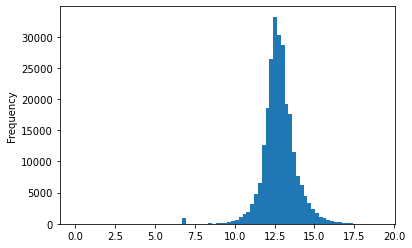

In [196]:
np.log(df.target).plot(kind = 'hist', bins = 80)

In [197]:
df.to_csv('Data_v_2.csv')

## RandomForestRegressor

In [198]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('target', axis =1), df.target, test_size=0.2, random_state=42)

In [199]:
RANDOM_SEED = 42

In [200]:
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)
# попробовать побольше деревьев

In [201]:
model.fit(X_train, np.log(y_train))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   53.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.0min finished


RandomForestRegressor(n_jobs=-1, random_state=42, verbose=1)

In [202]:
y_pred = model.predict(X_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.9s finished


In [203]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [204]:
mape(y_test, np.exp(y_pred))

0.5481142919927202

## XGBOOST

In [205]:
model = XGBRegressor()
model.fit(X_train, np.log(y_train))
y_pred = model.predict(X_test)

In [206]:
mape(y_test, np.exp(y_pred))

0.5687272670232019